In [48]:
# coding:u8
import pandas as pd
import numpy as np
import copy,gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score,classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import seaborn as sns



In [57]:
data = pd.read_pickle('features/1_stat_feature.pkl')

In [58]:
# data = data.fillna(-999)

In [59]:
data.head()

,text_id,kb_id,train_mention,label,num_attrs,num_abstract_words,num_alias,m_id,num_candidates,mention_equal_subject,...,rank_num_abstract_words,rank_num_alias,rank_label_mean,rank_label_count,rank_m_label_mean,rank_m_label_count,rank_num_candidates,rank_mention_equal_subject,rank_shuminghao,rank_entity_common
0,1,130287,南京南站,0,9,338,2,0,2,True,...,2.0,2.0,NaN,NaN,NaN,NaN,1.5,1.5,1.5,1.5
1,1,311223,南京南站,1,17,447,3,0,2,True,...,1.0,1.0,NaN,NaN,NaN,NaN,1.5,1.5,1.5,1.5
2,1,213561,高铁,0,1,0,2,1,2,False,...,2.0,1.0,2.0,1.5,2.0,1.5,1.5,2.0,1.5,2.0
3,1,341096,高铁,1,10,239,1,1,2,True,...,1.0,2.0,1.0,1.5,1.0,1.5,1.5,1.0,1.5,1.0
4,1,130287,南京南站,0,9,338,2,2,2,True,...,2.0,2.0,NaN,NaN,NaN,NaN,1.5,1.5,1.5,1.5


In [60]:

predictor = ['num_attrs',
       'num_abstract_words', 'num_alias', 'num_candidates',
       'mention_equal_subject', 'shuminghao', 'len_mention', 'mention_start',
       'academicdiscipline', 'animal', 'astronomicalobject', 'athlete',
       'awardeventseries', 'brand', 'building', 'collegeoruniversity',
       'communicationmedium', 'country', 'creativework', 'culturalheritage',
       'currency', 'curriculum', 'educationmajor', 'entertainmentperson',
       'event', 'familyname', 'fictionalhuman', 'fictionalthing', 'food',
       'formula', 'game', 'historicalperiod', 'historicalperson', 'human',
       'internationalorganization', 'language', 'material', 'medicalcondition',
       'medicaldepartmenttype', 'movie', 'nation', 'organism', 'organization',
       'person', 'place', 'plant', 'product', 'scientificorganization',
       'symbol', 'theorem', 'thing', 'tool', 'tvplay', 'tvshow', 'vocabulary',
       'zodiacsign', 'label_mean', 'label_count', 'm_label_mean',
       'm_label_count', 'rank_num_attrs', 'rank_num_abstract_words',
       'rank_num_alias', 'rank_label_mean', 'rank_label_count',
       'rank_m_label_mean', 'rank_m_label_count', 'rank_num_candidates',
       'rank_mention_equal_subject', 'rank_shuminghao', 'rank_entity_common','entity_common']

In [61]:
exclude = []
# exclude = []
temp = []
for x in predictor:
    if x not in exclude:temp.append(x)
predictor2 = temp

In [64]:
param = {
    #'num_leaves':100,
    'objective':'binary',
    #'metric':'acc',
    'metric_freq':20,
    'learning_rate': 0.05,
    'num_threads':8,
    #'min_sum_hessian_in_leaf':10,
    'boosting_type':'gbdt',
    'subsample':0.9,
    'colsample_bytree':0.8,
    'n_estimators':20000,
    'min_child_weight':1,
    'subsample_freq':2,
    'num_leaves':128,
    'n_jobs':-1,
}


In [63]:
val_data.shape

(191852, 79)

In [56]:
kfold = KFold(n_splits=9,shuffle=False,random_state=2019)
for train_index,test_index in kfold.split(data):
    train_data,val_data = data.loc[train_index,:],data.loc[test_index,:]
    train_data = train_data.fillna(-999)
    train = lgb.Dataset(train_data[predictor2],label=train_data['label'])
    validation_data = lgb.Dataset(val_data[predictor2],label=val_data['label'])
    
    val_data.reset_index(inplace=True,drop=True)
    val_data.reset_index(inplace=True)
    index_df = val_data.groupby('m_id')['index'].apply(list)
    
    label_package = val_data.groupby('m_id',as_index=False)['label'].agg({'label_id_max':'idxmax'})['label_id_max']
    
    def lgb_f1_score(y_hat, data):
        y_true = data.get_label()
        hit = 0
        for index,pack in enumerate(index_df):
            score = []
            for i in pack:
                score.append(y_hat[i])
            if pack[np.argmax(score)]==label_package[index]:
                hit+=1
        best_score = hit/len(index_df)
        return 'acc', best_score, True
    bst = lgb.train(param, train, valid_sets=[validation_data],early_stopping_rounds=500,
                    verbose_eval=20,feval=lgb_f1_score)
    
    # 观察阈值
    val_data['link_grade'] = bst.predict(val_data[predictor2])
    max_id = val_data.groupby('m_id',as_index=False)['link_grade'].agg({'max_id':'idxmax'})['max_id']
    val_data_temp = val_data.loc[max_id,:]
    # 假设label为１的数据有0.84的概率为真
    m = 0
    n = 0
    hit = 0
    for i in range(100):
        i = i/100
        filter_val = val_data_temp[val_data_temp['link_grade']>i]
        m = filter_val.shape[0]
        n = 28000
        hit = filter_val['label'].mean()*m*0.83
        acc = hit/m
        recall = hit/n
        f1 = 2*acc*recall/(acc+recall)
        print(f1,acc,recall,i)
        
# 0.8672
# 0.872
# [171]	valid_0's binary_logloss: 0.0988336	valid_0's acc: 0.873219
# valid_0's binary_logloss: 0.0964686	valid_0's acc: 0.87713
# [224]	valid_0's binary_logloss: 0.096617	valid_0's acc: 0.877515
# [308]	valid_0's binary_logloss: 0.09149	valid_0's acc: 0.890507 entity common
# drop ctr 0.877
# [2094]	valid_0's binary_logloss: 0.0791409	valid_0's acc: 0.896452
# [1674]	valid_0's binary_logloss: 0.0784442	valid_0's acc: 0.896347
#０．９１５
# [1344]	valid_0's binary_logloss: 0.0767459	valid_0's acc: 0.897395
# [405]	valid_0's binary_logloss: 0.0681472	valid_0's acc: 0.913129
# [1600]	valid_0's binary_logloss: 0.0672695	valid_0's acc: 0.91415


/home/zhukaihua/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[20]	valid_0's binary_logloss: 0.156002	valid_0's acc: 0.897853
[40]	valid_0's binary_logloss: 0.101787	valid_0's acc: 0.900422
[60]	valid_0's binary_logloss: 0.0840493	valid_0's acc: 0.902358
[80]	valid_0's binary_logloss: 0.0774897	valid_0's acc: 0.903766
[100]	valid_0's binary_logloss: 0.0746046	valid_0's acc: 0.905033
[120]	valid_0's binary_logloss: 0.0731082	valid_0's acc: 0.906195
[140]	valid_0's binary_logloss: 0.0722063	valid_0's acc: 0.906477
[160]	valid_0's binary_logloss: 0.0717091	valid_0's acc: 0.907251
[180]	valid_0's binary_logloss: 0.0713142	valid_0's acc: 0.907673
[200]	valid_0's binary_logloss: 0.0709891	valid_0's acc: 0.907885
[220]	valid_0's binary_logloss: 0.070801	valid_0's acc: 0.90799
[240]	valid_0's binary_logloss: 0.0706503	valid_0's acc: 0.908025
[260]	valid_0's binary_logloss: 0.0704554	valid_0's acc: 0.908377
[280]	valid_0's binary_logloss: 0.0703009	valid_0's acc: 0.90887
[300]	valid_0's binary

0.7640240778229636 0.7665095797836011 0.7615546428571428 0.33
0.7639267212791511 0.7668546442581063 0.7610210714285714 0.34
0.7637625787009632 0.7672168366427619 0.7603392857142857 0.35
0.7638228747846064 0.7677919312933025 0.7598946428571428 0.36
0.7637425660743481 0.7684785045377299 0.7590646428571428 0.37
0.7637707217087992 0.7690527916576146 0.7585607142857144 0.38
0.7637637234080846 0.7698323779116174 0.75779 0.39
0.7638834846519672 0.7706582582145972 0.7572267857142857 0.4
0.7637891737891737 0.771327481972467 0.7563967857142857 0.41
0.7638521913285098 0.7718881960398205 0.7559817857142856 0.42
0.7635364444123383 0.7722954113692825 0.7549739285714285 0.43
0.7631569811593679 0.7728550501721233 0.7536992857142857 0.44
0.7629113878230652 0.7733814031997651 0.7527210714285714 0.45
0.7629279254788959 0.7744508627984841 0.7517428571428572 0.46
0.7627654052091841 0.7755039675216829 0.7504385714285714 0.47
0.7625013175350281 0.7762267362267361 0.749252857142857 0.48
0.7624455483377913 0.7

/home/zhukaihua/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[20]	valid_0's binary_logloss: 0.153879	valid_0's acc: 0.899972
[40]	valid_0's binary_logloss: 0.100099	valid_0's acc: 0.901984
[60]	valid_0's binary_logloss: 0.0826168	valid_0's acc: 0.903997
[80]	valid_0's binary_logloss: 0.0760692	valid_0's acc: 0.905692
[100]	valid_0's binary_logloss: 0.0731835	valid_0's acc: 0.907139
[120]	valid_0's binary_logloss: 0.0717287	valid_0's acc: 0.907704
[140]	valid_0's binary_logloss: 0.07079	valid_0's acc: 0.90894
[160]	valid_0's binary_logloss: 0.0701931	valid_0's acc: 0.909187
[180]	valid_0's binary_logloss: 0.0697832	valid_0's acc: 0.909858
[200]	valid_0's binary_logloss: 0.0695421	valid_0's acc: 0.910211
[220]	valid_0's binary_logloss: 0.0693176	valid_0's acc: 0.910564
[240]	valid_0's binary_logloss: 0.0691391	valid_0's acc: 0.91067
[260]	valid_0's binary_logloss: 0.0689977	valid_0's acc: 0.91067
[280]	valid_0's binary_logloss: 0.0688089	valid_0's acc: 0.911164
[300]	valid_0's binary_l

KeyboardInterrupt: 

In [54]:
############################## for submit  #####################################

train = lgb.Dataset(data[predictor2],label=data['label'])
param = {
    #'num_leaves':100,
    'objective':'binary',
    #'metric':'acc',
    'metric_freq':20,
    'learning_rate': 0.05,
    'num_threads':8,
    #'min_sum_hessian_in_leaf':10,
    'boosting_type':'gbdt',
    'subsample':0.9,
    'colsample_bytree':0.8,
    'n_estimators':500,
    'min_child_weight':1,
    'subsample_freq':2,
    'num_leaves':128,
    'n_jobs':-1,
}

bst = lgb.train(param, train)
from sklearn.externals import joblib
joblib.dump(bst, 'model_link/lgb.pkl')

# save model
# load model
#gbm_pickle = joblib.load('lgb.pkl')
# break

/home/zhukaihua/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


['model_link/lgb.pkl']

In [ ]:
# val_data

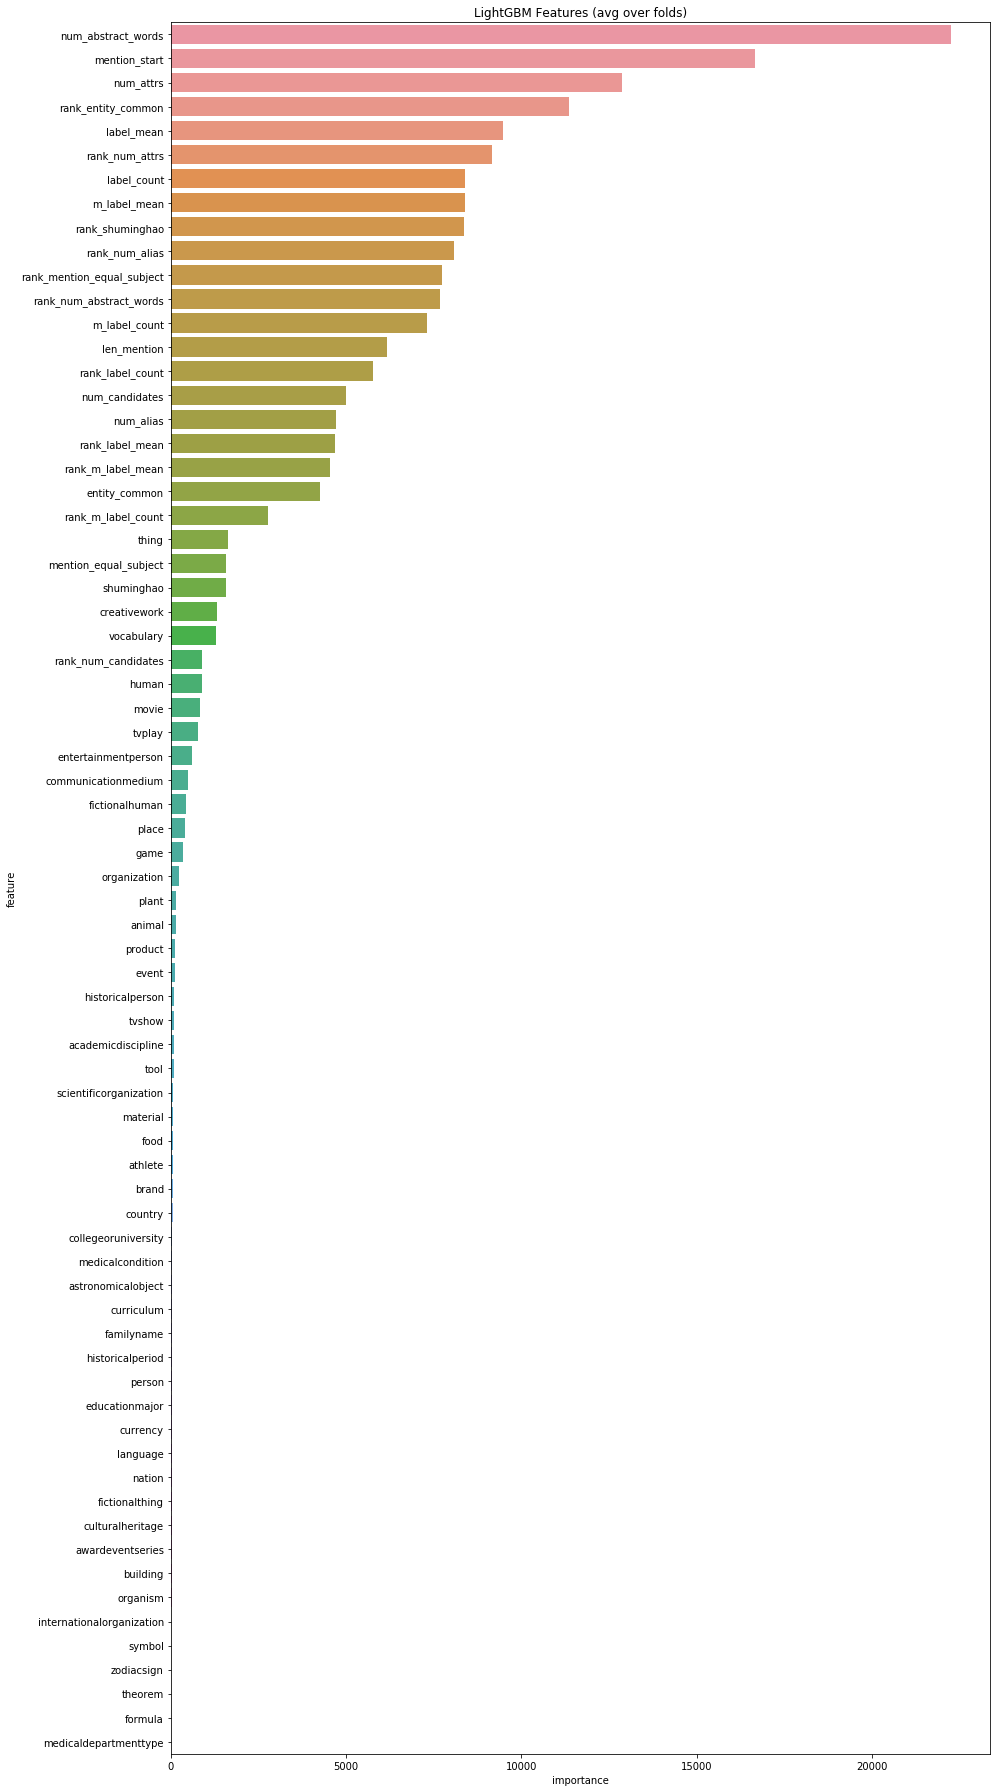

In [15]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = predictor2
fold_importance_df["importance"] = bst.feature_importance()
cols = (fold_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = predictor2
fold_importance_df["importance"] = bst.feature_importance()
cols = (fold_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')